# **Social Media Computing Tutorial 10 & 11**
Dataset used: [IMDB Dataset for 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [1]:
# Load and Clean Data
import pandas as pd
import re
import nltk
import spacy
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
nlp = spacy.load("en_core_web_sm")

# Load dataset and sample 1000 rows
df = pd.read_csv("IMDB Dataset.csv").sample(1000, random_state=42)

# Function to clean text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|\#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Lemmatization
    doc = nlp(text)
    lemmatized = ' '.join([token.lemma_ for token in doc if token.lemma_ not in stop_words])
    
    return lemmatized

df['clean_review'] = df['review'].apply(clean_text)
df.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\GF63\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GF63\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review,sentiment,clean_review
33553,I really liked this Summerslam due to the look...,positive,really like summerslam due look arena curtain ...
9427,Not many television shows appeal to quite as m...,positive,many television show appeal quite many differe...
199,The film quickly gets to a major chase scene w...,negative,film quickly get major chase scene ever increa...
12447,Jane Austen would definitely approve of this o...,positive,jane austen would definitely approve onegwynet...
39489,Expectations were somewhat high for me when I ...,negative,expectation somewhat high go see movie think s...


### Rule-Based Aspect Extraction (Dependency Parsing)

In [2]:
import spacy
from collections import defaultdict

nlp = spacy.load("en_core_web_sm")
aspects = defaultdict(list)

for doc in nlp.pipe(df['clean_review'].tolist()):
    for token in doc:
        if token.pos_ == 'ADJ':
            for child in token.children:
                if child.pos_ == 'NOUN':
                    aspects[child.lemma_].append(token.lemma_)

# Print top 10 aspect-opinion pairs
for asp, ops in list(aspects.items())[:10]:
    print(f"Aspect: {asp}, Opinions: {ops}")


Aspect: episode, Opinions: ['unique', 'funny', 'hammond', 'bad']
Aspect: camera, Opinions: ['specific', 'bad', 'excellent', 'ill']
Aspect: tickle, Opinions: ['funnybonecritic']
Aspect: place, Opinions: ['tony', 'familiar', 'surprising']
Aspect: character, Opinions: ['particular', 'believable', 'clichs', 'dimensional', 'different', 'strong', 'minimal', 'particular', 'bad', 'obnoxious', 'unaware', 'unbelievable', 'final', 'cool', 'likable', 'amiable', 'bad', 'interesting', 'explosive', 'successful', 'realistic', 'childish', 'fictional', 'great', 'cool', 'interesting', 'great', 'bad', 'important', 'easy', 'apparent']
Aspect: scene, Opinions: ['clichd', 'favourite', 'complete', 'old', 'predictable', 'usual', 'bad', 'bad', 'particular']
Aspect: safety, Opinions: ['sharky']
Aspect: movie, Opinions: ['terrible', 'unconnected', 'bad', 'afraid', 'hilarious', 'transvestite', 'bad', 'empty', 'french', 'favorite', 'imaginative', 'great', 'interesting', 'glad', 'commercial', 'enjoyment', 'total', '

### Unsupervised Machine Learning (Guided LDA)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
dtm = vectorizer.fit_transform(df['clean_review'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

for idx, topic in enumerate(lda.components_):
    print(f"Topic #{idx}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Topic #0:
['good', 'year', 'alien', 'lou', 'come', 'doctor', 'time', 'mary', 'make', 'film']
Topic #1:
['role', 'really', 'man', 'story', 'make', 'play', 'like', 'good', 'film', 'movie']
Topic #2:
['think', 'time', 'character', 'watch', 'good', 'bad', 'make', 'like', 'movie', 'film']
Topic #3:
['watch', 'play', 'time', 'make', 'story', 'great', 'love', 'good', 'film', 'movie']
Topic #4:
['people', 'kill', 'snake', 'life', 'leave', 'man', 'know', 'really', 'guy', 'film']


### Supervised Machine Learning (Fine-tuned BERT)

In [4]:
import transformers
import accelerate

print("Transformers version:", transformers.__version__)
print("Accelerate version:", accelerate.__version__)


d:\Degree\Third Year\SEM 2\Social Media Computing\Tutorials\Sentiment Analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Transformers version: 4.52.4
Accelerate version: 1.7.0


In [5]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

# Convert sentiment to numerical labels
df = df[df['sentiment'].isin(['positive', 'negative'])]  # filter out any unknowns
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Tokenization
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
def tokenize_fn(batch):
    return tokenizer(batch['clean_review'], padding='max_length', truncation=True, max_length=128)

dataset = Dataset.from_pandas(df[['clean_review', 'label']])
dataset = dataset.map(tokenize_fn, batched=True)
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Train-test split
split = dataset.train_test_split(test_size=0.2)
train_ds = split['train']
val_ds = split['test']

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
)

trainer.train()


Map: 100%|██████████| 1000/1000 [00:01<00:00, 660.36 examples/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\Degree\Third Year\SEM 2\Social Media Computing\Tutorials\Sentiment Analysis\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.696800,0.698112
2,0.601600,0.612156
3,0.619300,0.687839
4,0.445400,0.750680
5,0.405000,0.574880


d:\Degree\Third Year\SEM 2\Social Media Computing\Tutorials\Sentiment Analysis\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\Degree\Third Year\SEM 2\Social Media Computing\Tutorials\Sentiment Analysis\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\Degree\Third Year\SEM 2\Social Media Computing\Tutorials\Sentiment Analysis\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\Degree\Third Year\SEM 2\Social Media Computing\Tutorials\Sentiment Analysis\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWa

TrainOutput(global_step=500, training_loss=0.6085234913825989, metrics={'train_runtime': 2031.6329, 'train_samples_per_second': 1.969, 'train_steps_per_second': 0.246, 'total_flos': 263111055360000.0, 'train_loss': 0.6085234913825989, 'epoch': 5.0})

In [6]:
# Get predictions (probabilities)
predictions = trainer.predict(val_ds)
pred_probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)

# Convert to labels (0=negative, 1=positive)
pred_labels = torch.argmax(pred_probs, dim=1).numpy()
true_labels = val_ds['label'].numpy()

d:\Degree\Third Year\SEM 2\Social Media Computing\Tutorials\Sentiment Analysis\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.86      0.78       104
    positive       0.81      0.65      0.72        96

    accuracy                           0.76       200
   macro avg       0.76      0.75      0.75       200
weighted avg       0.76      0.76      0.75       200



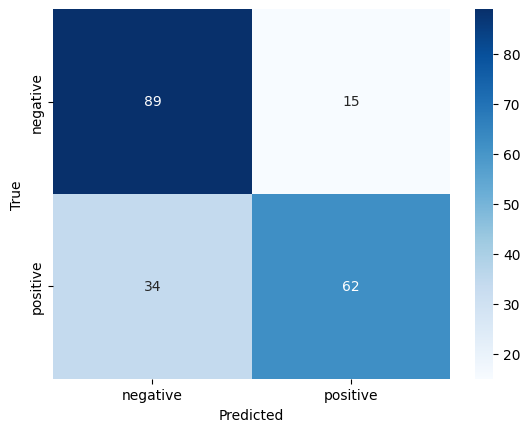

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels, 
                           target_names=['negative', 'positive']))

# Confusion matrix plot
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['negative', 'positive'],
           yticklabels=['negative', 'positive'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [8]:
from sklearn.metrics import roc_auc_score, accuracy_score

# AUC-ROC (requires probability scores)
auc = roc_auc_score(true_labels, pred_probs[:,1]) 
print(f"AUC-ROC: {auc:.3f}")

# Accuracy
acc = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {acc:.3f}")

AUC-ROC: 0.855
Accuracy: 0.755


## Entity-Level Sentiment Analysis

In [9]:
def analyze_entity_sentiments(text, sentiment_model):
    """
    Analyze sentiment for each entity in the text
    Returns dictionary of {entity: [sentiment_dicts]}
    """
    doc = nlp(text)
    entity_sentiments = defaultdict(list)
    
    # Analyze sentiment for each sentence containing entities
    for sent in doc.sents:
        entities_in_sent = [ent.text for ent in sent.ents]
        if entities_in_sent:
            # Get sentiment for the whole sentence
            sentiment = sentiment_model(sent.text[:512])[0]  # Truncate to model max length
            
            # Associate sentiment with each entity in sentence
            for entity in entities_in_sent:
                entity_sentiments[entity].append({
                    "text": sent.text,
                    "label": sentiment['label'],
                    "score": sentiment['score']
                })
    
    return entity_sentiments

In [14]:
from transformers import pipeline

# Initialize sentiment analysis model
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert/distilbert-base-uncased-finetuned-sst-2-english",
    device="cpu"  # or device=0 for GPU
)

Device set to use cpu


In [15]:
# Example usage
sample_review = """
The Dark Knight features Heath Ledger's incredible performance as Joker.
Christian Bale was good as Batman, but the plot felt rushed.
Nolan's direction was brilliant as always.
"""

results = analyze_entity_sentiments(sample_review, sentiment_analyzer)

# Print results
for entity, sentiments in results.items():
    print(f"\nEntity: {entity}")
    for s in sentiments:
        print(f"- {s['label']} ({s['score']:.2f}): {s['text']}")


Entity: Heath Ledger's
- POSITIVE (1.00): 
The Dark Knight features Heath Ledger's incredible performance as Joker.


Entity: Joker
- POSITIVE (1.00): 
The Dark Knight features Heath Ledger's incredible performance as Joker.


Entity: Christian Bale
- NEGATIVE (1.00): Christian Bale was good as Batman, but the plot felt rushed.


Entity: Batman
- NEGATIVE (1.00): Christian Bale was good as Batman, but the plot felt rushed.


Entity: Nolan
- POSITIVE (1.00): Nolan's direction was brilliant as always.



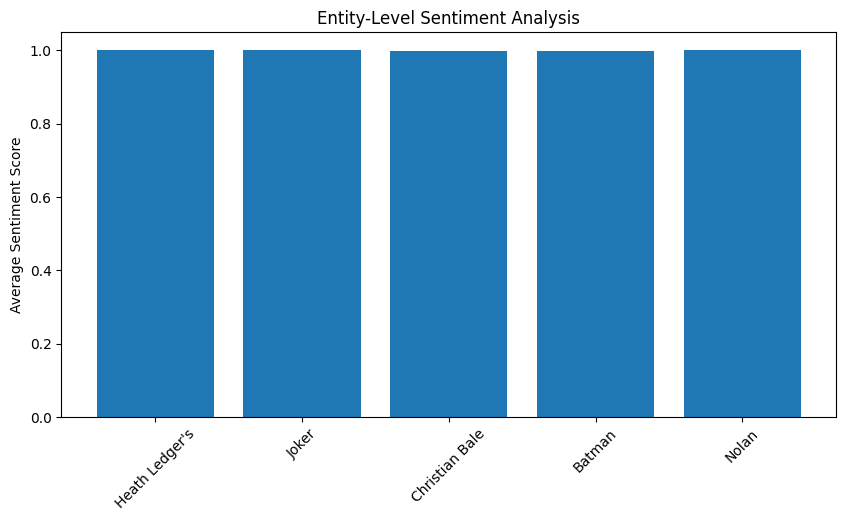

In [16]:
import matplotlib.pyplot as plt

# Calculate average sentiment scores per entity
entity_avg_scores = {
    entity: sum(s['score'] for s in sentiments)/len(sentiments) 
    for entity, sentiments in results.items()
}

# Plot
plt.figure(figsize=(10, 5))
plt.bar(entity_avg_scores.keys(), entity_avg_scores.values())
plt.xticks(rotation=45)
plt.ylabel("Average Sentiment Score")
plt.title("Entity-Level Sentiment Analysis")
plt.show()

In [17]:
# Analyze first 10 reviews
for i, review in enumerate(df['review'].head(10)):
    print(f"\n\nReview {i+1}:")
    results = analyze_entity_sentiments(review, sentiment_analyzer)
    
    for entity, sentiments in results.items():
        print(f"\nEntity: {entity}")
        for s in sentiments:
            print(f"- {s['label']} ({s['score']:.2f}): {s['text'][:50]}...")



Review 1:

Entity: Summerslam
- POSITIVE (1.00): I really liked this Summerslam due to the look of ...
- POSITIVE (0.99): Anyways, this could have been one of the best Summ...

Entity: WWF
- POSITIVE (0.99): Anyways, this could have been one of the best Summ...

Entity: Lex Luger
- POSITIVE (0.99): Anyways, this could have been one of the best Summ...
- POSITIVE (0.60): Other matches on the card were Razor Ramon vs Ted ...

Entity: Yokozuna
- POSITIVE (0.99): Anyways, this could have been one of the best Summ...
- POSITIVE (0.60): Other matches on the card were Razor Ramon vs Ted ...

Entity: Luger
- NEGATIVE (1.00): It was a terrible main event just like every match...

Entity: Razor Ramon
- POSITIVE (0.60): Other matches on the card were Razor Ramon vs Ted ...

Entity: Ted Dibiase
- POSITIVE (0.60): Other matches on the card were Razor Ramon vs Ted ...

Entity: Steiner Brothers
- POSITIVE (0.60): Other matches on the card were Razor Ramon vs Ted ...

Entity: Heavenly Bodies
- POSIT